### *ML project*


---



# **Restaurant Recommender System**

*Jiaqi Wang

In [ ]:
conda install shap

Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/osx-64::numpy-devel==1.18.5=py38h4ba5984_0
  - defaults/noarch::sphinx==4.0.2=pyhd3eb1b0_0
  - conda-forge/noarch::google-auth-oauthlib==0.4.6=pyhd8ed1ab_0
  - defaults/noarch::pyopenssl==20.0.1=pyhd3eb1b0_1
  - conda-forge/osx-64::xgboost==1.1.1=py38hc84c608_0
  - defaults/osx-64::mkl_random==1.1.1=py38h959d312_0
  - defaults/noarch::keras-base==2.4.3=pyhd3eb1b0_0
  - conda-forge/noarch::google-pasta==0.2.0=pyh8c360ce_0
  - defaults/noarch::jsonschema==3.2.0=py_2
  - defaults/osx-64::numpy-base==1.18.5=py38h3304bdc_0
  - conda-forge/osx-64::h5py==2.10.0=nompi_py38h106b333_102
  - defaults/osx-64::scikit-learn==0.24.2=py38hb2f4e1b_0
  - conda-forge/noarch::tensorflow-estimator==2.4.0=pyh9656e83_0
  - conda-forge/osx-64::py-xgboost==1.1.1=py38h32f6830_0
  - defaults/osx-64::argon2-cffi==20.1.0=py38h9ed2024_1
  - defaults/noa

In [1]:
# Load the Python libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import xgboost as xgb
import difflib
import random
import surprise
import shap

# Load Surprise libraries
from surprise import SVD
from surprise import Reader
from surprise import Dataset
from surprise import accuracy
from surprise import SlopeOne, CoClustering, KNNBasic, KNNWithMeans, KNNWithZScore
from surprise.prediction_algorithms import knns
from surprise.similarities import cosine, msd, pearson
from surprise.model_selection import GridSearchCV

# Load plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("BrBG_r")
sns.set_style('whitegrid')

In [2]:
# Load the data
payment = pd.read_csv('chefmozaccepts.csv')
cuisine = pd.read_csv('chefmozcuisine.csv')
time = pd.read_csv('chefmozhours4.csv')
parking = pd.read_csv('chefmozparking.csv')
data = pd.read_csv('rating_final.csv')
location = pd.read_csv('geoplaces2.csv')
user_cuisine = pd.read_csv('usercuisine.csv')
user_payment = pd.read_csv('userpayment.csv')
user = pd.read_csv('userprofile.csv')

## **Data Cleaning**

### Restaurant Information

In [3]:
# Data cleaning-location
location = location[location != '?']
col = ['placeID','name','alcohol','smoking_area','dress_code','accessibility','price','Rambience','franchise','area','other_services']

filter_method = lambda alcohol: 'no-served' if alcohol == 'No_Alcohol_Served' else 'served'
location['alcohol'] = location['alcohol'].apply(filter_method)

filter_method = lambda smoking_area: 'no' if smoking_area == any(['none','not permitted']) else 'yes'
location['smoking_area'] = location['smoking_area'].apply(filter_method)

filter_method = lambda franchise: 'yes' if franchise == 'f' else 'no'
location['franchise'] = location['franchise'].apply(filter_method)

location = location[col].dropna()

/Users/celiawang/opt/anaconda3/envs/celia/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [4]:
# Data cleaning-parking
parking.loc[parking['parking_lot'] == 'none', 'parking_lot'] = 'N'
parking.loc[parking['parking_lot'] != 'N', 'parking_lot'] = 'Y'
parking = parking.drop_duplicates()
parking = pd.get_dummies(parking)
parking = parking.groupby(by='placeID').sum().reset_index('placeID')

In [5]:
# Data cleaning-payment
payment.loc[payment['Rpayment'] != 'cash', 'Rpayment'] = 'card'
payment = payment.drop_duplicates()
payment = pd.get_dummies(payment)
payment = payment.groupby(by='placeID').sum().reset_index('placeID')

In [6]:
# Data cleaning-cuisine
filter_method = lambda Rcuisine: \
    'Mexican' if any([Rcuisine=='Mexican']) else 'other' 
cuisine['Rcuisine'] = cuisine['Rcuisine'].apply(filter_method)
cuisine = cuisine.drop_duplicates()
cuisine = pd.get_dummies(cuisine)
cuisine = cuisine.groupby(by='placeID').sum().reset_index('placeID')

In [7]:
# Merge parking, payment and cuisine tables
restaurants = location.merge(parking, on='placeID', how = 'outer').merge(cuisine, on='placeID', how = 'outer').merge(payment, on='placeID', how = 'outer')
restaurants = restaurants.dropna()

In [8]:
data = pd.merge(data, location[['placeID', 'name']], on='placeID')
data = data[['userID', 'placeID' ,'name', 'rating', 'food_rating', 'service_rating']]

In [9]:
res_all = np.concatenate((payment.placeID, cuisine.placeID, 
                          time.placeID, parking.placeID, location.placeID))
res_all = np.sort( np.unique(res_all) ) # All the placeID's

print("There are {} restaurants.".format(len(res_all)))

There are 938 restaurants.


In [10]:
user_all = np.concatenate((user_cuisine.userID, user_payment.userID, user.userID))
user_all = np.sort( np.unique(user_all) ) # All the userID's

print("There are {} users.".format(len(user_all)))

There are 138 users.


## **Explotary Analysis**

In [11]:
overall_rating = pd.DataFrame( np.zeros((len(res_all),len(user_all)))-1.0, 
                              columns=user_all, index=res_all )
food_rating = overall_rating.copy()
service_rating = overall_rating.copy() 

for r, u, o, f, s in zip(data.placeID, data.userID, data.rating, data.food_rating, 
                         data.service_rating):
    overall_rating.loc[r,u] = o
    food_rating.loc[r,u] = f
    service_rating.loc[r,u] = s

# This tells us whether a restaurant-user pair has a rating. 0 means No and 1 means Yes.
review = pd.DataFrame( np.zeros(overall_rating.shape), columns=user_all, index=res_all)
review[overall_rating >= 0] = 1

In [12]:
# These are the ones that might be relevant
res_features = location

df_res = pd.DataFrame({'placeID': res_all})

df_res = pd.merge(left=df_res, right=cuisine, how="left", on="placeID")
df_res = pd.merge(left=df_res, right=parking, how="left", on="placeID")
df_res = pd.merge(left=df_res, right=payment, how="left", on="placeID")
df_res = pd.merge(left=df_res, right=res_features, how="left", on="placeID")

In [13]:
# The placeID's for the 130 restaurants with ratings
res_rated = res_all[np.sum(review,axis=1) > 0] 

# tells us whether a restaurant-user pair has a rating. 0 means No and 1 means Yes.
R = review.loc[res_rated].values  # shape = (130,138)

# Now these have a shape of (130, 138) too
Y_overall = overall_rating.loc[res_rated].values
Y_food  = food_rating.loc[res_rated].values
Y_service = service_rating.loc[res_rated].values

# select the indices of "df_res" where a restaurant has ratings
index = [x in res_rated for x in df_res['placeID'].values] #np.array()

# restaurant features for the 130 restaurants with ratings
X = df_res.loc[index, :].reset_index(drop=True)

X.isnull().sum() # all the NANs are from cuisine 

placeID              0
Rcuisine_Mexican    35
Rcuisine_other      35
parking_lot_N        0
parking_lot_Y        0
Rpayment_card       16
Rpayment_cash       16
name                 0
alcohol              0
smoking_area         0
dress_code           0
accessibility        0
price                0
Rambience            0
franchise            0
area                 0
other_services       0
dtype: int64

In [14]:
# fill all NANs with 0
X = X.fillna(0) 

# There are the restaurant features we'll explore
X.columns.values 

array(['placeID', 'Rcuisine_Mexican', 'Rcuisine_other', 'parking_lot_N',
       'parking_lot_Y', 'Rpayment_card', 'Rpayment_cash', 'name',
       'alcohol', 'smoking_area', 'dress_code', 'accessibility', 'price',
       'Rambience', 'franchise', 'area', 'other_services'], dtype=object)

In [15]:
#user
user_info = user

In [16]:
# Calculate the mean rating for each restaurant
def GetMean(Y,R):

    Y = Y*R
    mean =  (np.sum(Y, axis=1)/np.sum((R == 1.0), axis=1)).reshape(Y.shape[0],1)
    return mean

Y_overall_mean = GetMean(Y_overall,R)
Y_food_mean = GetMean(Y_food,R)
Y_service_mean = GetMean(Y_service,R)

In [17]:
# This is the function I'll use to plot and print the mean ratings of different 
# groups of restaurants based on different values of a given feature
def plot_mean_rating(df,rotate=False):
    
    n = df.shape[1]
    columns = df.columns.values
    
    if n > 1:
        y_overall = [ Y_overall_mean[df[i] == 1].mean() for i in columns ]
        y_food = [ Y_food_mean[df[i] == 1].mean() for i in columns ]
        y_service = [ Y_service_mean[df[i] == 1].mean() for i in columns ] 
        y = pd.DataFrame({'overall':y_overall, 'food':y_food, 'service':y_service},
                         columns=['overall','food','service'],index=columns) 
        ticks = columns
        
    else:
        values = df[columns[0]].unique()
        values = values[values != '?']
        y_overall = [ Y_overall_mean[df[columns[0]] == i].mean() for i in values ]
        y_food = [ Y_food_mean[df[columns[0]] == i].mean() for i in values ]
        y_service = [ Y_service_mean[df[columns[0]] == i].mean() for i in values ] 
        y = pd.DataFrame({'overall':y_overall, 'food':y_food, 'service':y_service},
                         columns=['overall','food','service'],index=values) 
        ticks = values
   
    fig = plt.figure()
    plt.plot(range(y.shape[0]),y['overall'],'-o',c='orange',label='overall')
    plt.plot(range(y.shape[0]),y['food'],'-o',c='green',label='food')   
    plt.plot(range(y.shape[0]),y['service'],'-o',c='black',label='service')
    plt.xticks(range(y.shape[0]),ticks,fontsize=13)
    if rotate: plt.xticks(rotation=40)
    plt.yticks(fontsize=13) 
    if n == 1: plt.xlabel(columns[0],fontsize=15)
    plt.ylabel('mean rating',fontsize=15)
    plt.legend(fontsize=15,frameon=False)
    plt.show()
    
    print(y)

In [18]:
# This function is similar to the one above, but this time the result is split
# into different groups of users as well
def plot_mean_rating_split(df,userinfo,rotate=False):
    
    n = df.shape[1]
    columns = df.columns.values
    
    cases = userinfo.unique()
    cases = cases[cases != '?']
    
    num = len(cases)
    y = {}
    
    if n > 1:
        
        for i in range(num):
            
            index = (userinfo == cases[i])
            R_case = np.zeros(R.shape)
            R_case[:,index] = R[:,index]

            Y_overall_case = GetMean(Y_overall,R_case)
            Y_food_case = GetMean(Y_food,R_case)
            Y_service_case = GetMean(Y_service,R_case)
        
            isnan = np.isnan(Y_overall_case).reshape(-1)
            y_overall = [Y_overall_case[(df[j] == 1) & 
                        (isnan == False)].mean() for j in columns]
            y_food = [Y_food_case[(df[j] == 1) & 
                     (isnan == False)].mean() for j in columns]
            y_service = [Y_service_case[(df[j] == 1) & 
                        (isnan == False)].mean() for j in columns]
            
            y[cases[i]] = pd.DataFrame({'overall':y_overall, 'food':y_food, 'service':
                          y_service}, columns=['overall','food','service'],index=columns)
            
        ticks = columns

     
    else:
        
        for i in range(num):
            
            values = df[columns[0]].unique()
            values = values[values != '?']
            
            index = (userinfo == cases[i])
            R_case = np.zeros(R.shape)
            R_case[:,index] = R[:,index]

            Y_overall_case = GetMean(Y_overall,R_case)
            Y_food_case = GetMean(Y_food,R_case)
            Y_service_case = GetMean(Y_service,R_case)
        
            isnan = np.isnan(Y_overall_case).reshape(-1)
            y_overall = [Y_overall_case[(df[columns[0]] == j) & 
                        (isnan == False)].mean() for j in values]
            y_food = [Y_food_case[(df[columns[0]] == j) & 
                     (isnan == False)].mean() for j in values]
            y_service = [Y_service_case[(df[columns[0]] == j) & 
                        (isnan == False)].mean() for j in values]
                        
            y[cases[i]] = pd.DataFrame({'overall':y_overall, 'food':y_food, 'service':
                          y_service}, columns=['overall','food','service'],index=values)

        ticks = values
   

    f, (ax1, ax2, ax3) = plt.subplots(1,3, sharex=True, sharey=True, figsize=(24,6))
 
    color = ['k','r','b'] 

    for i in range(num):
        ax1.plot(range(len(ticks)),y[cases[i]]['overall'],'-o',c=color[i],label=cases[i])
        ax2.plot(range(len(ticks)),y[cases[i]]['food'],'-o',c=color[i],label=cases[i])
        ax3.plot(range(len(ticks)),y[cases[i]]['service'],'-o',c=color[i],label=cases[i])
    
    ax1.set_title('overall',fontsize=20)
    ax2.set_title('food',fontsize=20)
    ax3.set_title('service',fontsize=20)

    ax1.tick_params(labelsize=16)
    ax2.tick_params(labelsize=16)
    ax3.tick_params(labelsize=16)
    
    if rotate:
        ax1.set_xticks(range(len(ticks)))
        ax1.set_xticklabels(ticks, rotation=40)
        ax2.set_xticks(range(len(ticks)))
        ax2.set_xticklabels(ticks, rotation=40)
        ax3.set_xticks(range(len(ticks)))
        ax3.set_xticklabels(ticks, rotation=40)
    else:
        plt.xticks(range(len(ticks)),ticks)
                           
    if n == 1: 
        ax2.set_xlabel(columns[0],fontsize=20)
    
    ax1.set_ylabel('mean rating',fontsize=20)
    
    plt.legend(fontsize=20,frameon=False)
    plt.show()
    
    return y

### Distribution of Rating

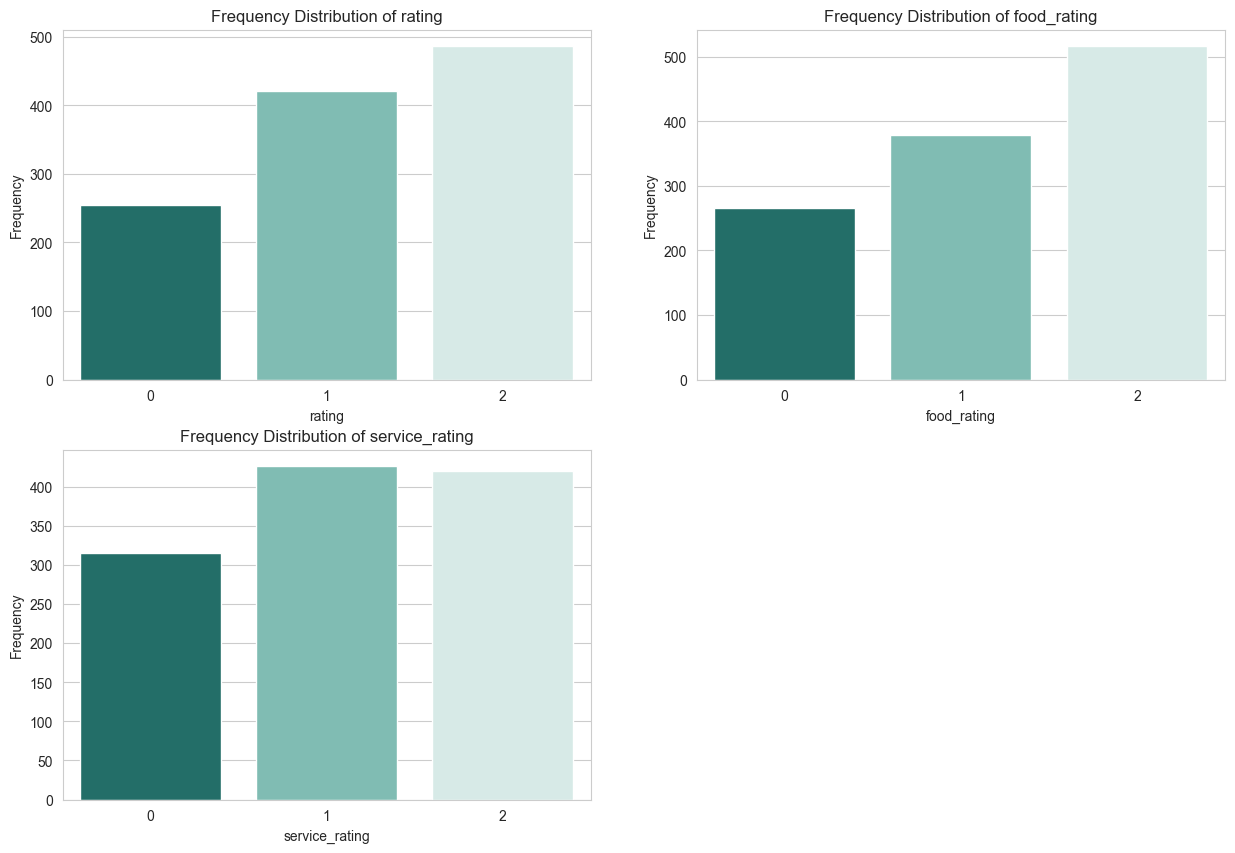

In [19]:
# Visualise the distribution of rating, food_rating and service_rating features

columns_to_plot = ['rating', 'food_rating', 'service_rating']


plt.figure(figsize=(15, 10))
for i, col in enumerate(columns_to_plot):
    plt.subplot(2, 2, i+1)
    sns.countplot(data=data, x=col)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.title("Frequency Distribution of {}".format(col))    
plt.show()

###Rating by Price

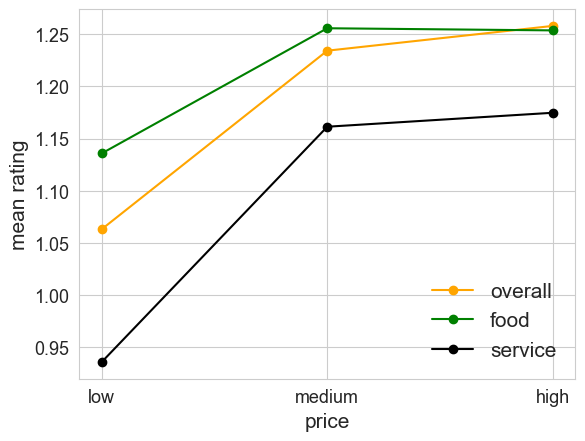

         overall      food   service
low     1.063059  1.135805  0.935632
medium  1.234342  1.255871  1.161361
high    1.258106  1.253816  1.174754


In [20]:
# mean rating as a function of price
plot_mean_rating(X[['price']])

<ipython-input-16-1496b359cd4c>:5: RuntimeWarning: invalid value encountered in true_divide
  mean =  (np.sum(Y, axis=1)/np.sum((R == 1.0), axis=1)).reshape(Y.shape[0],1)


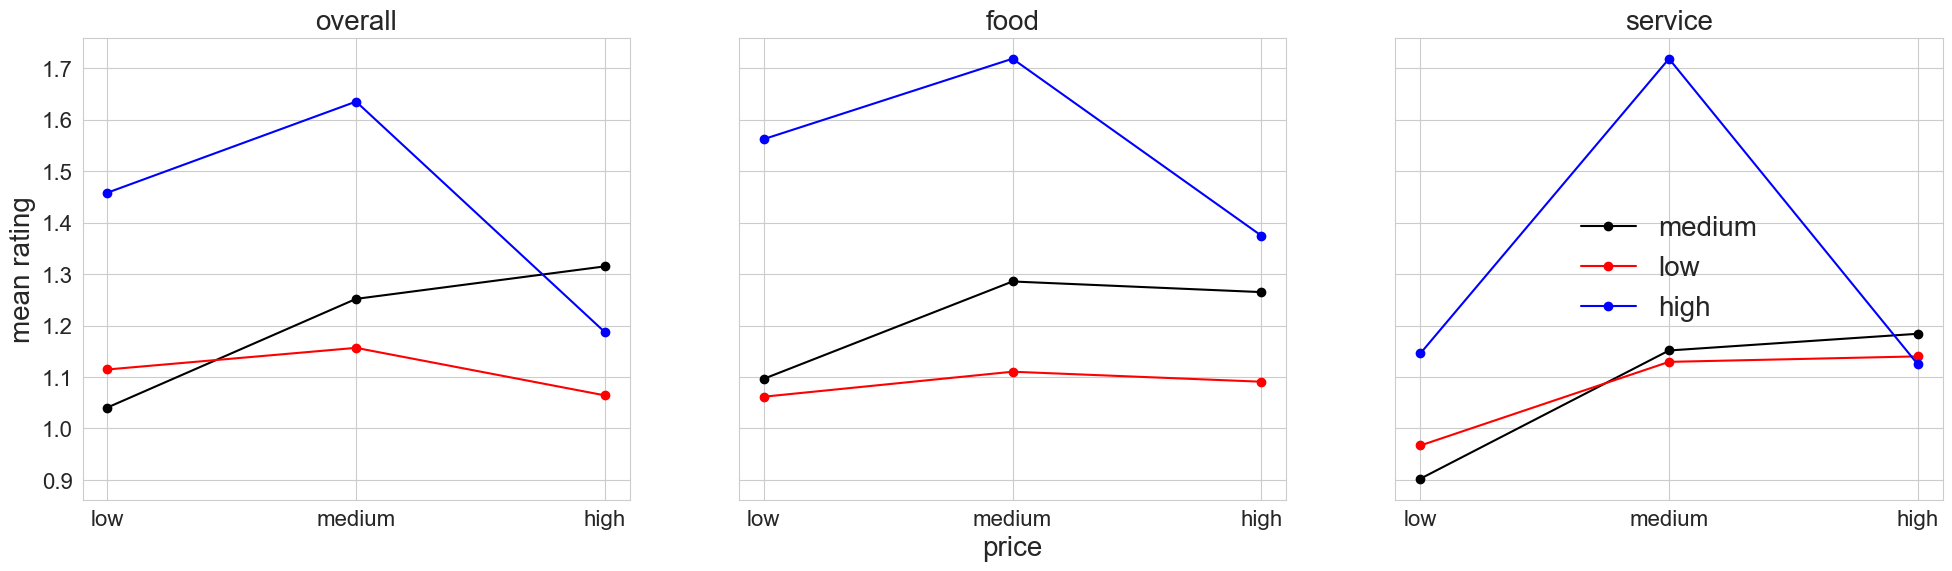

low budget:
         overall      food   service
low     1.114693  1.061776  0.966924
medium  1.156722  1.110335  1.129481
high    1.064394  1.090909  1.140152

medium budget:
         overall      food   service
low     1.040752  1.096643  0.902340
medium  1.251914  1.285747  1.151604
high    1.315073  1.265112  1.184063

high budget:
         overall     food   service
low     1.458333  1.56250  1.145833
medium  1.635417  1.71875  1.718750
high    1.187500  1.37500  1.125000


In [21]:
# mean rating as a function of price, split into three groups of consumers
# with low, medium, and high budget
y = plot_mean_rating_split(X[['price']],user_info.budget)

print('low budget:')
print(y['low'])
print('\nmedium budget:')
print(y['medium'])
print('\nhigh budget:')
print(y['high'])

###Rating by Cuisine

In [22]:
columns = ['Rcuisine_Mexican','Rcuisine_other']

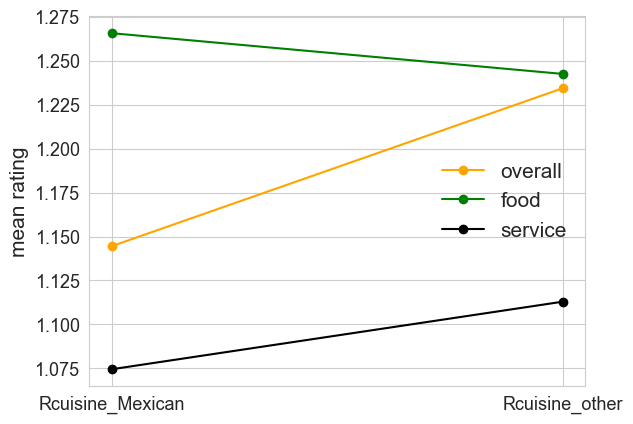

                   overall      food   service
Rcuisine_Mexican  1.144555  1.265529  1.074582
Rcuisine_other    1.234276  1.242388  1.112969


In [23]:
# mean rating as a function of cuisine
plot_mean_rating(X[columns])

###Rating by Parking

In [24]:
columns = ['parking_lot_N','parking_lot_Y']

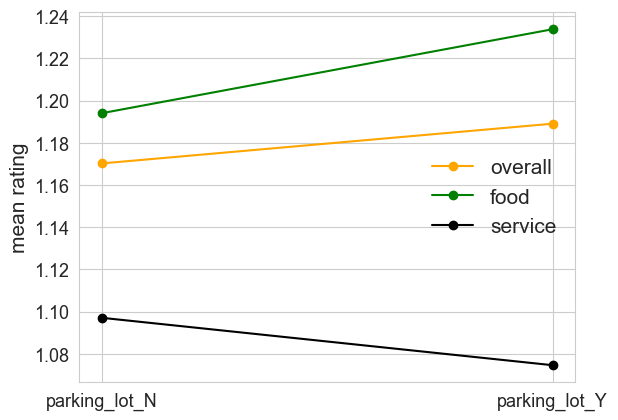

                overall      food   service
parking_lot_N  1.170202  1.194014  1.097035
parking_lot_Y  1.189041  1.233815  1.074564


In [25]:
# mean rating as a function of parking
plot_mean_rating(X[columns])

###Rating by Payment

In [26]:
columns = ['Rpayment_card','Rpayment_cash']

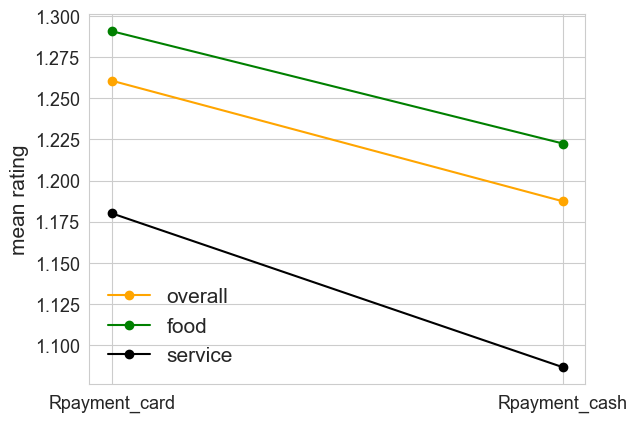

                overall      food   service
Rpayment_card  1.260712  1.290844  1.180008
Rpayment_cash  1.187363  1.222524  1.086425


In [27]:
# mean rating as a function of payment
plot_mean_rating(X[columns])

###Rating by Alcohol

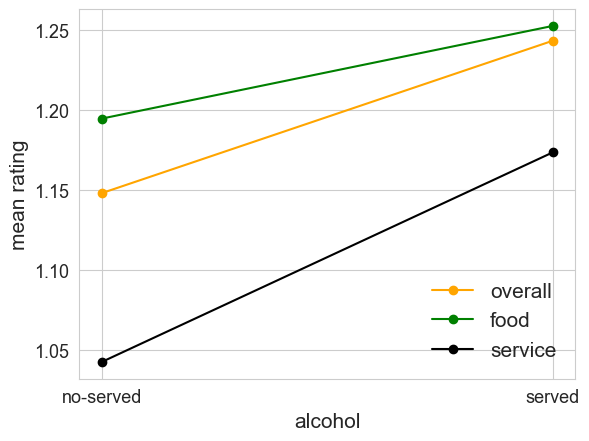

            overall     food   service
no-served  1.148075  1.19473  1.042417
served     1.243448  1.25273  1.173573


In [28]:
# mean rating as a function of alcohol
plot_mean_rating(X[['alcohol']])

###Rating by Dress Code

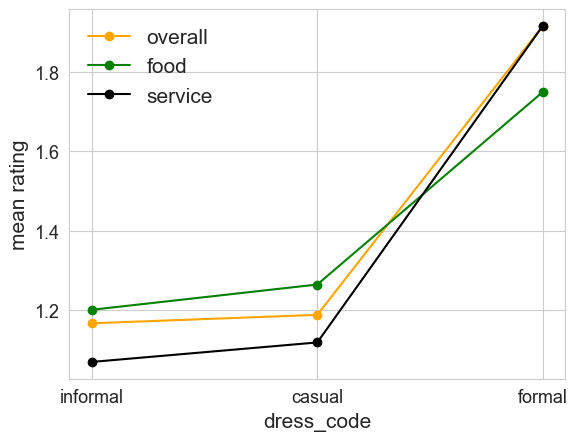

           overall      food   service
informal  1.166441  1.200562  1.068978
casual    1.187739  1.264256  1.118116
formal    1.916667  1.750000  1.916667


In [29]:
# mean rating as a function of dress code
plot_mean_rating(X[['dress_code']])

###Rating by Accessibility

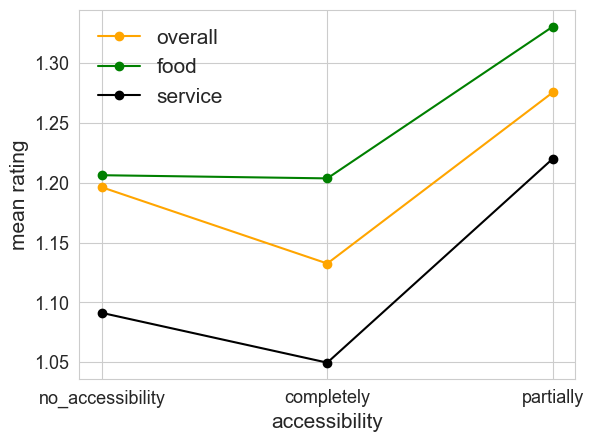

                   overall      food   service
no_accessibility  1.196189  1.206242  1.091278
completely        1.132494  1.203597  1.049709
partially         1.275356  1.330294  1.219991


In [30]:
# mean rating as a function of accessibility
plot_mean_rating(X[['accessibility']])

###Rating by Ambience

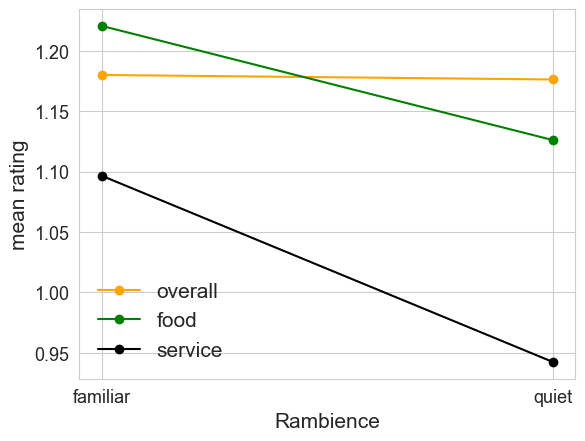

           overall      food   service
familiar  1.179880  1.220451  1.096459
quiet     1.176144  1.126035  0.942484


In [31]:
# mean rating as a function of ambience
plot_mean_rating(X[['Rambience']])

###Rating by Franchise

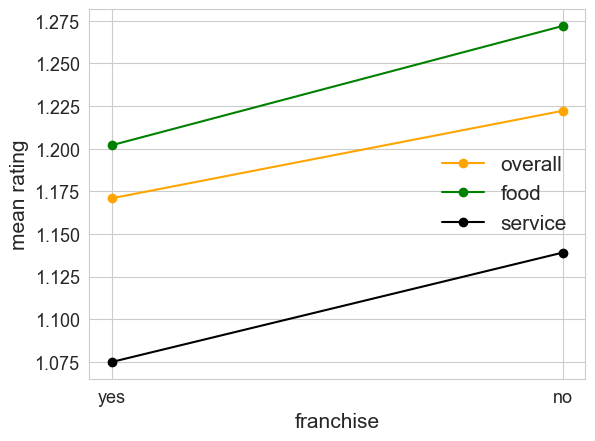

     overall      food   service
yes  1.17094  1.202081  1.074945
no   1.22224  1.272006  1.139087


In [32]:
# mean rating as a function of franchise
plot_mean_rating(X[['franchise']])

### Rating by Area

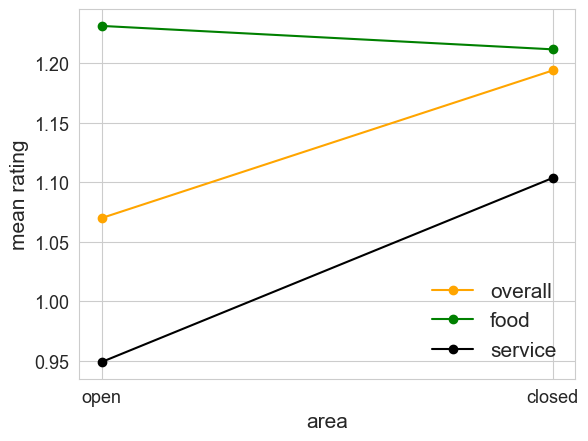

         overall      food   service
open    1.069992  1.231315  0.949101
closed  1.193921  1.211645  1.103630


In [33]:
# mean rating as a function of area
plot_mean_rating(X[['area']])

### Rating by Other Services

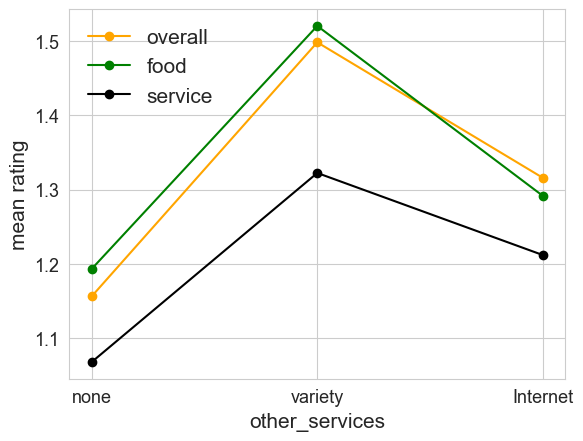

           overall      food   service
none      1.156273  1.193252  1.067643
variety   1.498639  1.520748  1.322449
Internet  1.315972  1.291667  1.211806


In [34]:
# mean rating as a function of other service
plot_mean_rating(X[['other_services']])

## **Recommender System**

### Collaborative-Filtering

In [35]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=40)

In [36]:
#trasform dataframe to surprise form
reader = Reader(rating_scale = (0, 2))
data_train1 = Dataset.load_from_df(trainset[['userID', 'placeID', 'rating']], reader)
data_test = Dataset.load_from_df(testset[['userID', 'placeID', 'rating']], reader)

In [37]:
# Build full trainset
data_train = data_train1.build_full_trainset()
data_test = data_test.build_full_trainset()

In [38]:
# Create the trainset and testset
data_trainset = data_train.build_testset()
data_testset = data_test.build_testset()

In [39]:
#user-based KNN

#KNNBasic
sim_cos = {'name':'cosine', 'user_based':True}
basic_cos = knns.KNNBasic(sim_options=sim_cos)
basic_cos.fit(data_train)
predictions = basic_cos.test(data_testset)
print(accuracy.rmse(predictions))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7931
0.7930799710096783


/Users/celiawang/opt/anaconda3/envs/celia/lib/python3.8/site-packages/surprise/prediction_algorithms/algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


In [40]:
#KNNWithMeans
sim_pearson = {'name':'pearson', 'user_based':True}
knn_means = knns.KNNWithMeans(sim_options=sim_pearson)
knn_means.fit(data_train)
predictions = knn_means.test(data_testset)
print(accuracy.rmse(predictions))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.6509
0.6509422263701349


In [41]:
#KNNWithZScore
sim_pearson = {'name':'pearson', 'user_based':True}
knn_zscore = knns.KNNWithZScore(sim_options=sim_pearson)
knn_zscore.fit(data_train)
predictions = knn_zscore.test(data_testset)
print(accuracy.rmse(predictions))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.6458
0.6458271332201261


In [42]:
#item-based KNN

#KNNBasic
sim_pearson = {'name':'pearson', 'user_based':False}
basic_pearson = knns.KNNBasic(sim_options=sim_pearson)
basic_pearson.fit(data_train)
predictions = basic_pearson.test(data_testset)
print(accuracy.rmse(predictions))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.6687
0.6687320160189824


In [43]:
#KNNWithMeans
sim_pearson = {'name':'pearson', 'user_based':False}
knn_means = knns.KNNWithMeans(sim_options=sim_pearson)
knn_means.fit(data_train)
predictions = knn_means.test(data_testset)
print(accuracy.rmse(predictions))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.6990
0.6990124133211926


In [44]:
#KNNWithZScore
sim_pearson = {'name':'pearson', 'user_based':False}
knn_means = knns.KNNWithZScore(sim_options=sim_pearson)
knn_means.fit(data_train)
predictions = knn_means.test(data_testset)
print(accuracy.rmse(predictions))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.7079
0.7078771557161699


In [45]:
#SVD
# Create SVD algorithm with 3 factors
k_factors = 3
algo = SVD(n_factors= k_factors, n_epochs= 200, lr_all= 0.005, reg_all= 0, init_mean= 0, init_std_dev= 0.001)

In [46]:
# Train the algorithm on the trainset
algo.fit(data_train)

In [47]:
# Calculate RMSE for test dataset
test_pred = algo.test(data_testset)
accuracy.rmse(test_pred)

RMSE: 0.6008


0.6007626111053446

In [48]:
#Try tuning parameter selection
#KNNbasic

sim_options = {
    "name": ["msd", "cosine"],
    "min_support": [1,2,3, 4, 5,6,7,8],
    "user_based": [False, True],
}

param_grid = {"sim_options": sim_options}

knn_basic = GridSearchCV(knns.KNNBasic, param_grid, measures=["rmse", "mae"], cv=5,refit=True)
knn_basic.fit(data_train1)
pred = knn_basic.test(data_testset)
rmse = accuracy.rmse(pred)
knn_basic_results = rmse
print(knn_basic.best_params["rmse"])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [49]:
#KNNwithmeans

sim_options = {
    "name": ["msd", "cosine"],
    "min_support": [1,2,3, 4, 5,6,7,8],
    "user_based": [False, True],
}

param_grid = {"sim_options": sim_options}

knn_means = GridSearchCV(knns.KNNWithMeans, param_grid, measures=["rmse", "mae"], cv=5,refit=True)

knn_means.fit(data_train1)
pred = knn_means.test(data_testset)
rmse = accuracy.rmse(pred)
knn_means_results = rmse
print(knn_means.best_params["rmse"])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

In [50]:
#KNNwithzscore

sim_options = {
    "name": ["msd", "cosine"],
    "min_support": [1,2,3, 4, 5,6,7,8],
    "user_based": [False, True],
}

param_grid = {"sim_options": sim_options}

knn_zscore = GridSearchCV(knns.KNNWithZScore, param_grid, measures=["rmse", "mae"], cv=5,refit=True)

knn_zscore.fit(data_train1)

pred = knn_zscore.test(data_testset)
rmse = accuracy.rmse(pred)
knn_zscore_results = rmse
print(knn_zscore.best_params["rmse"])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

In [62]:
my_seed = 42
random.seed(my_seed)
np.random.seed(my_seed)

In [67]:
#SVD
param_grid = {'n_epochs': [400], 'lr_all': [0.001,0.1,5],
              'reg_all': [0.001,0.1,5]}
svd = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5, refit=True, joblib_verbose=2)



svd.fit(data_train1)
pred = svd.test(data_testset)
rmse = accuracy.rmse(pred)
svd_results = rmse
print(svd.best_params["rmse"])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   29.7s finished


RMSE: 0.5935
{'n_epochs': 400, 'lr_all': 0.001, 'reg_all': 0.001}


In [69]:
svd_results

0.5935313653572041

In [70]:
# Concat the results of all the models
results = np.array((svd_results,
                    knn_basic_results, 
                    knn_means_results,
                    knn_zscore_results))

result_df = pd.DataFrame(results, 
                         index=['SVD', 'KNN_Basic', 'KNN_Means','KNN_Zscore'], columns=['RMSE'])

In [71]:
result_df.sort_values(by='RMSE')

,RMSE
KNN_Basic,0.583880
KNN_Means,0.590160
KNN_Zscore,0.590160
SVD,0.593531


## **Generate Recommendations using SVD**

In [72]:
# 1. Get the restaurant id from restaurant name
def get_rest_id(rest_name, data):
    
    '''Returns the Restaurant ID (placeID) given the restaurant Name.'''
    
    rest_names = list(data['name'].values)
    
    # Using difflib find the restaurants that are closest to the input and extract the corresponding placeID
    
    closest_names = difflib.get_close_matches(rest_name, rest_names)
    rest_id = data[data['name'] == closest_names[0]]['placeID'].iloc[0]
    
    return rest_id

# 2. Predict the rating for this restaurant for a given user (b/w 0-2)
def predict_rating(user_id, rest_name, data, model=svd):
    
    # extract the restaurant id from the restaurant name
    rest_id = get_rest_id(rest_name, data)
    #print(rest_id)
    
    # make predictions
    estimated_ratings = model.predict(user_id,rest_id)
    
    return estimated_ratings.est

# 3. Generate Recommendations for a given user

'''
In this, we will take userID as the input and output the names of all the restaurants for which the given user is most likely to
give a rating above a certain threshold rating (1.5 in this case).
'''
def recommend_restaurants(user_id, data=data, model=svd, threshold=1.5):
    
    # store the recommended restaurants along with the predicted ratings given by the user in a dictionary
    recommended_restaurants = {}
    
    # Find all the unique restaurant names
    unique_rest_names = list(np.unique(data['name'].values))
    
    # Shuffle the restaurant name list
    random.shuffle(unique_rest_names)
    
    # iterate over the list and generate ratings(predictions) for each restaurant and return only those which have a rating > threshold (1.5)
    for rest_name in unique_rest_names:
        
        # generate predictions
        #print(rest_name)
        rating = predict_rating(user_id=user_id, rest_name=rest_name, data=data, model=svd)
        
        # check if rating > threshold
        if rating > threshold:
            
            recommended_restaurants[rest_name] = np.round(rating,2)
    
    print("Generating Restaurant Recommendations for User ID {} : ".format(user_id))
    
    restaurant_names = np.array(list(recommended_restaurants.keys())).reshape(-1,1)
    restaurant_ratings = np.array(list(recommended_restaurants.values())).reshape(-1,1)
    
    results = np.concatenate((restaurant_names, restaurant_ratings), axis=1)
    results_df = pd.DataFrame(results, columns=['Restaurants', 'Rating (0-2)']).sort_values(by='Rating (0-2)', ascending=False)
    
    return results_df.reset_index().drop('index', axis=1)

In [73]:
# Randomly pick up a userID using np.random.choice
random_user_id = np.random.choice(list(np.unique(data['userID'].values)))

# Generate Recommendations for the user ID
recommend_restaurants(user_id = random_user_id)

Generating Restaurant Recommendations for User ID U1033 : 


,Restaurants,Rating (0-2)
0,Restaurant Las Mananitas,2.0
1,La Virreina,1.95
2,Tortas Locas Hipocampo,1.92
3,crudalia,1.9
4,Restaurante la Gran Via,1.9
...,...,...
57,Subway,1.52
58,Cabana Huasteca,1.52
59,Restaurante Bar El Gallinero,1.52
60,carnitas_mata,1.52


In [74]:
# filter top 10
recommend_restaurants(user_id = random_user_id).head(10)

Generating Restaurant Recommendations for User ID U1033 : 


,Restaurants,Rating (0-2)
0,Restaurant Las Mananitas,2.0
1,La Virreina,1.95
2,Tortas Locas Hipocampo,1.92
3,Restaurante la Gran Via,1.9
4,crudalia,1.9
5,cafe punta del cielo,1.88
6,Mariscos El Pescador,1.86
7,La Cantina Restaurante,1.8
8,Dominos Pizza,1.79
9,La Estrella de Dimas,1.78


## **XGBoost Model**

In [75]:
ratings = pd.DataFrame(data.groupby('placeID')['rating'].mean())  
ratings['count'] = pd.DataFrame(data.groupby('placeID')['rating'].count()) 
ratings.sort_values('count', ascending = False).head(10)

,rating,count
placeID,,
135085,1.333333,36
132825,1.281250,32
135032,1.178571,28
135052,1.280000,25
132834,1.000000,25
135038,1.208333,24
135060,1.136364,22
135062,1.238095,21
135042,1.250000,20


In [76]:
dataset = location.merge(ratings['rating'], on='placeID' ,how='left')
dataset = dataset.iloc[: , 2:]

In [77]:
dataset = pd.get_dummies(dataset)

In [78]:
# Select last column of dataframe as a series
y = dataset.iloc[: , 0]

# # Select all but the last column of dataframe 
X = dataset.iloc[: , 1:]

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=40)

In [80]:
from sklearn.model_selection import GridSearchCV

params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500,1000],
           'colsample_bylevel': [0.5, 0.7]}

xgbr = xgb.XGBRegressor(seed = 20)
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
clf.fit(X_train, y_train)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'colsample_bylevel': 0.5, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Lowest RMSE:  0.337592204352644


In [81]:
y_pred = clf.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

RMSE: 0.372974


In [82]:
xgb = xgb.XGBRegressor(colsample_bylevel= 0.5, learning_rate= 0.05, max_depth= 3, n_estimators= 100)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [83]:
xgb.feature_importances_

array([0.0367974 , 0.03325048, 0.        , 0.01243568, 0.11354799,
       0.06993378, 0.03268906, 0.06230976, 0.01860942, 0.0070972 ,
       0.11695278, 0.05562237, 0.0387911 , 0.01157872, 0.07566395,
       0.09839647, 0.03024803, 0.03095938, 0.        , 0.06561964,
       0.08949674], dtype=float32)

In [85]:
sorted_idx = xgb.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], xgb.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

Text(0.5, 23.52222222222222, 'Xgboost Feature Importance')

In [86]:
dataset.columns

Index(['rating', 'alcohol_no-served', 'alcohol_served', 'smoking_area_yes',
       'dress_code_casual', 'dress_code_formal', 'dress_code_informal',
       'accessibility_completely', 'accessibility_no_accessibility',
       'accessibility_partially', 'price_high', 'price_low', 'price_medium',
       'Rambience_familiar', 'Rambience_quiet', 'franchise_no',
       'franchise_yes', 'area_closed', 'area_open', 'other_services_Internet',
       'other_services_none', 'other_services_variety'],
      dtype='object')

In [87]:
xgb.feature_importances_[sorted_idx]

array([0.        , 0.        , 0.0070972 , 0.01157872, 0.01243568,
       0.01860942, 0.03024803, 0.03095938, 0.03268906, 0.03325048,
       0.0367974 , 0.0387911 , 0.05562237, 0.06230976, 0.06561964,
       0.06993378, 0.07566395, 0.08949674, 0.09839647, 0.11354799,
       0.11695278], dtype=float32)

In [88]:
pd.DataFrame(xgb.feature_importances_[sorted_idx],X.columns[sorted_idx])

,0
smoking_area_yes,0.000000
other_services_Internet,0.000000
price_high,0.007097
Rambience_quiet,0.011579
dress_code_casual,0.012436
accessibility_partially,0.018609
area_closed,0.030248
area_open,0.030959
accessibility_completely,0.032689
alcohol_served,0.033250


### SHAP

In [89]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train)

ModuleNotFoundError: No module named 'shap'

In [85]:
j = 30
player_explainer = pd.DataFrame()
player_explainer['feature'] = X.columns
player_explainer['feature_value'] = X_train.iloc[j].values
player_explainer['shap_value'] = shap_values[j]
player_explainer['base'] = xgb.predict(X_train).mean() 
player_explainer['sum'] = player_explainer['shap_value'].sum() 
player_explainer['base+sum'] = player_explainer['base']+player_explainer['sum']

In [86]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[j], X_train.iloc[j])

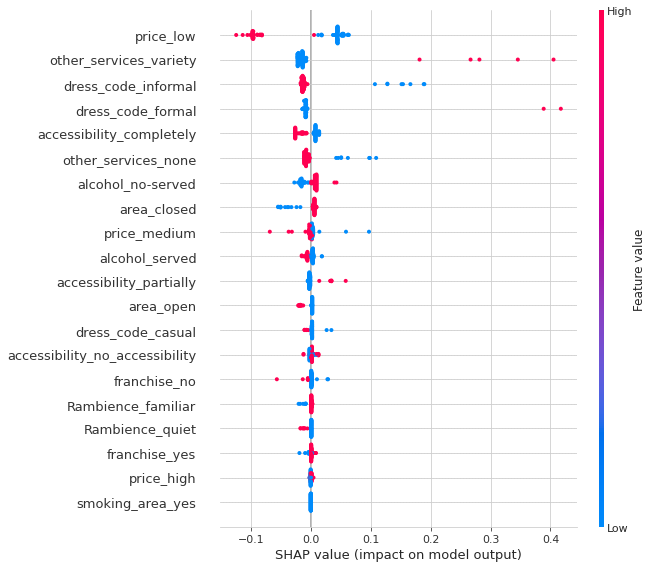

In [87]:
shap.summary_plot(shap_values, X_train)

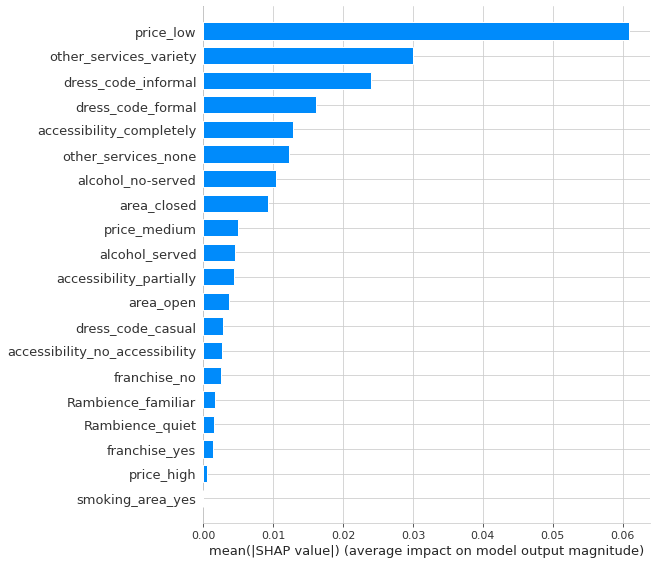

In [88]:
shap.summary_plot(shap_values, X_train, plot_type="bar")